# Assignment 3: Thompson Sampling for Multi-armed Bandits

- Tommy - Tongle Shen

In [2]:
import pandas as pd
import numpy as np 
import random
import matplotlib.pyplot as plt

## Data Preprocessing

Code from previous assignments

In [3]:
ratings = pd.read_csv('../dataset/ml-1m/ratings.dat', sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python', encoding='ISO-8859-1')
movies = pd.read_csv('../dataset/ml-1m/movies.dat', sep='::', names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')

data = pd.merge(ratings, movies, on='MovieID')

data['Genres'] = data['Genres'].str.split('|')
data = data.explode('Genres')

arms_rewards_df = data.groupby('Genres')['Rating'].apply(list).reset_index()

## Problem 1

In [4]:
class ThompsonSampling:
    def __init__(self, k, n, B=4):
        self.k = k
        self.n = n
        self.B = B
        
        self.arm_means = np.zeros(k)
        self.arm_counts = np.zeros(k)
        
        self.cumulative_regret = np.zeros(n)
        self.average_regret = np.zeros(n)
    
    def select_arm(self, t):
        sampled_values = np.zeros(self.k)
        for i in range(self.k):
            if self.arm_counts[i] == 0:
                return i
            variance = self.B**2 / (4 * self.arm_counts[i])
            sampled_values[i] = np.random.normal(self.arm_means[i], np.sqrt(variance))
        return np.argmax(sampled_values)
    
    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.arm_means[arm] += (reward - self.arm_means[arm]) / self.arm_counts[arm]
    
    def run(self, rewards, n):
        optimal_reward = 5
        for t in range(n):
            arm = self.select_arm(t)
            reward = random.choice(rewards[arm])
            self.update(arm, reward)
            regret = optimal_reward - reward
            self.cumulative_regret[t] = self.cumulative_regret[t - 1] + regret if t > 0 else regret
            self.average_regret[t] = self.cumulative_regret[t] / (t + 1)

Running expr 1
Running expr 2
Running expr 3
Running expr 4
Running expr 5
Running expr 6
Running expr 7
Running expr 8
Running expr 9
Running expr 10


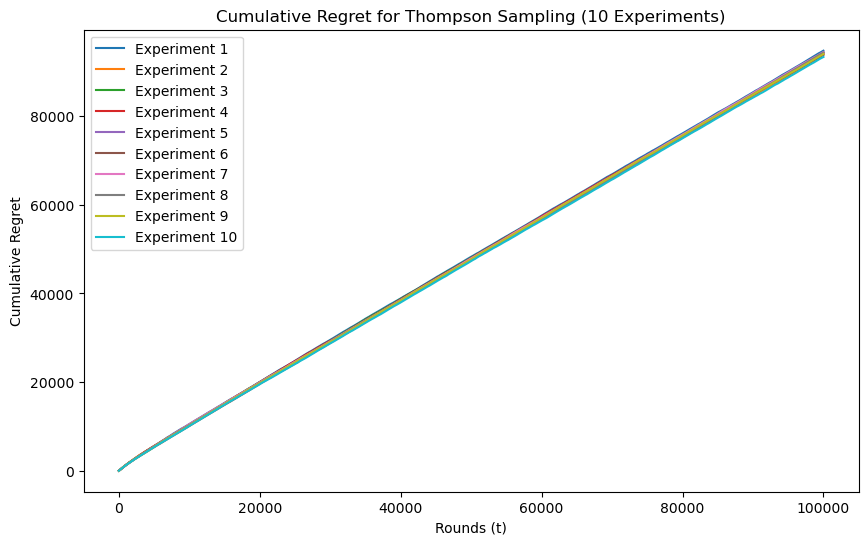

In [7]:
n = 100000
num_experiments = 10

all_cumulative_regrets = []
for _ in range(num_experiments):
    print(f"Running expr {_+1}")
    ts = ThompsonSampling(k=len(arms_rewards_df), n=n, B=4)
    ts.run(arms_rewards_df['Rating'], n)
    all_cumulative_regrets.append(ts.cumulative_regret)

plt.figure(figsize=(10, 6))
for i in range(num_experiments):
    plt.plot(all_cumulative_regrets[i], label=f'Experiment {i+1}')
plt.xlabel('Rounds (t)')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret for Thompson Sampling (10 Experiments)')
plt.legend()
plt.show()

Observation: Cumulative regrets from Thompson Sampling were slightly different, but close to each other since it simutaneously select the largest reward arm with best sampled confidence and mean value

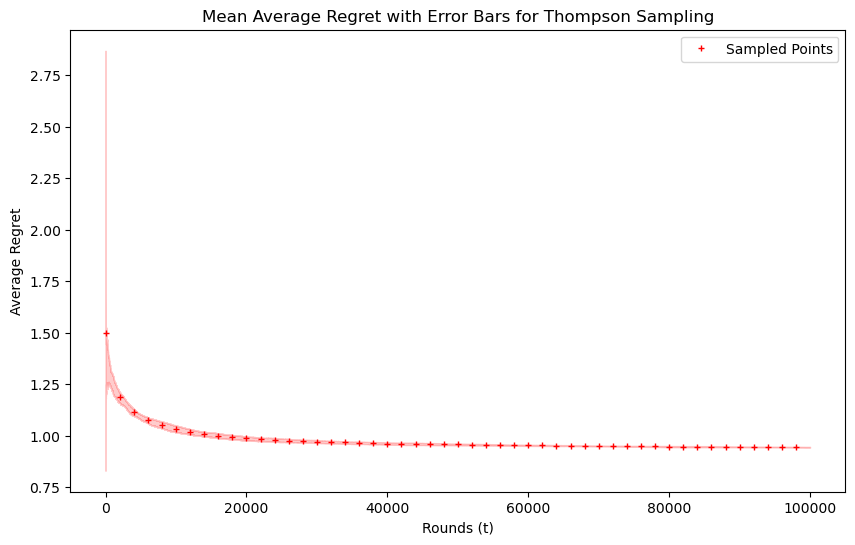

In [8]:
num_experiments = 100
all_cumulative_regrets = []

for _ in range(num_experiments):
    ts = ThompsonSampling(k=len(arms_rewards_df), n=n, B=4)
    ts.run(arms_rewards_df['Rating'], n)
    all_cumulative_regrets.append(ts.cumulative_regret)

all_cumulative_regrets = np.array(all_cumulative_regrets)

mean_cumulative_regret = np.mean(all_cumulative_regrets, axis=0)
std_cumulative_regret = np.std(all_cumulative_regrets, axis=0)

average_regret = mean_cumulative_regret / np.arange(1, n + 1)
std_average_regret = std_cumulative_regret / np.arange(1, n + 1)

sampling_interval = 2000
sampled_x = np.arange(0, n, sampling_interval)
sampled_average_regret = average_regret[::sampling_interval]

plt.figure(figsize=(10, 6))

plt.plot(sampled_x, sampled_average_regret, 'r+', markersize=5, label='Sampled Points')

plt.fill_between(range(n), average_regret - std_average_regret, average_regret + std_average_regret, color='red', alpha=0.2)

plt.xlabel('Rounds (t)')
plt.ylabel('Average Regret')
plt.title('Mean Average Regret with Error Bars for Thompson Sampling')

plt.legend()
plt.show()

## Problem 2

Copy code from previous assignment for the experiment

In [9]:
class ETC:
    def __init__(self, k, n, exploration_fraction=0.1):
        self.k = k
        self.n = n
        self.exploration_length = int(exploration_fraction * n)
        
        self.arm_means = np.zeros(k)
        self.arm_counts = np.zeros(k)
        
        self.cumulative_regret = np.zeros(n)
        self.average_regret = np.zeros(n)
    
    def select_arm(self, t):
        if t < self.exploration_length:
            return t % self.k
        else:
            return np.argmax(self.arm_means)
    
    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.arm_means[arm] += (reward - self.arm_means[arm]) / self.arm_counts[arm]
    
    def run(self, rewards, n):
        optimal_reward = 5
        for t in range(n):
            arm = self.select_arm(t)
            reward = random.choice(rewards[arm])
            self.update(arm, reward)
            regret = optimal_reward - reward
            self.cumulative_regret[t] = self.cumulative_regret[t - 1] + regret if t > 0 else regret
            self.average_regret[t] = self.cumulative_regret[t] / (t + 1)

In [10]:
class UCB:
    def __init__(self, k, n, B=4):
        self.k = k
        self.n = n
        self.B = B
        
        self.arm_means = np.zeros(k)
        self.arm_counts = np.zeros(k)
        
        self.cumulative_regret = np.zeros(n)
        self.average_regret = np.zeros(n)
    
    def select_arm(self, t):
        ucb_values = np.zeros(self.k)
        for i in range(self.k):
            if self.arm_counts[i] == 0:
                return i
            ucb_values[i] = self.arm_means[i] + self.B * np.sqrt(4 * np.log(self.n) / (2 * self.arm_counts[i]))
        return np.argmax(ucb_values)
    
    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.arm_means[arm] += (reward - self.arm_means[arm]) / self.arm_counts[arm]
    
    def run(self, rewards, n):
        optimal_reward = 5
        for t in range(n):
            arm = self.select_arm(t)
            reward = random.choice(rewards[arm])
            self.update(arm, reward)
            regret = optimal_reward - reward
            self.cumulative_regret[t] = self.cumulative_regret[t - 1] + regret if t > 0 else regret
            self.average_regret[t] = self.cumulative_regret[t] / (t + 1)

----------Running horizon 500----------


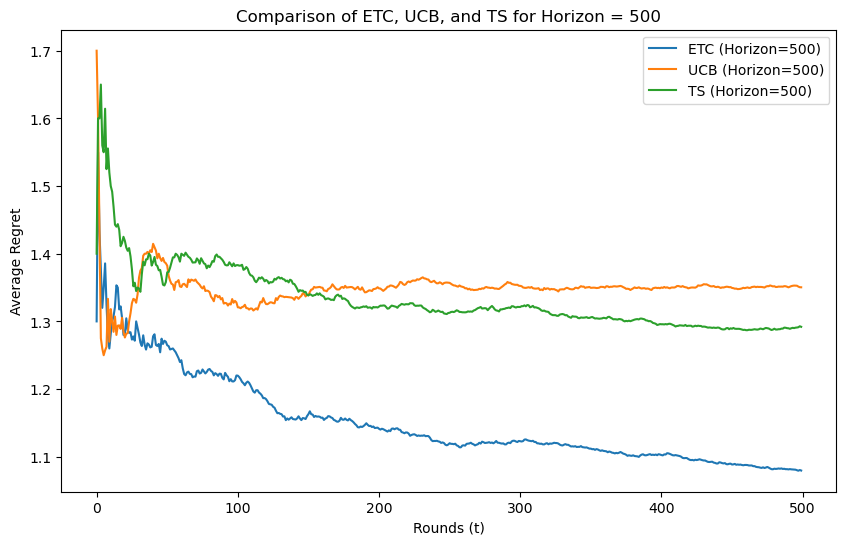

----------Running horizon 5000----------


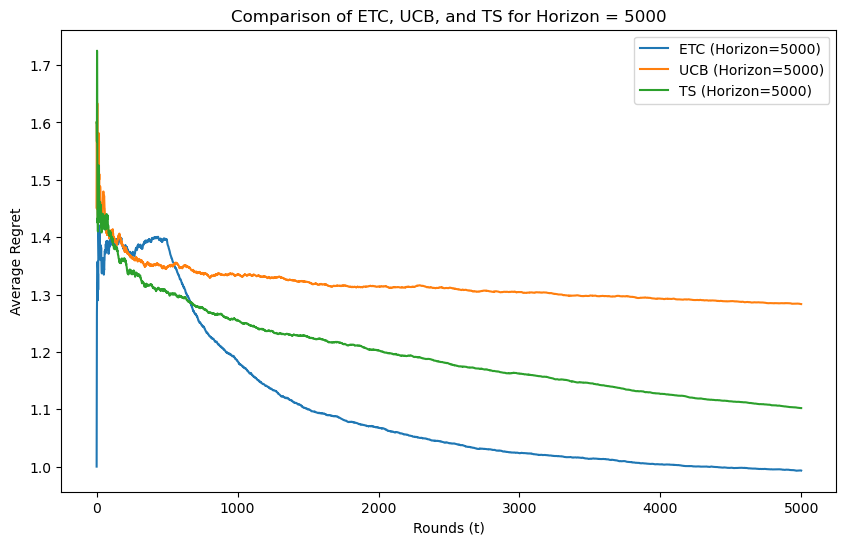

----------Running horizon 50000----------


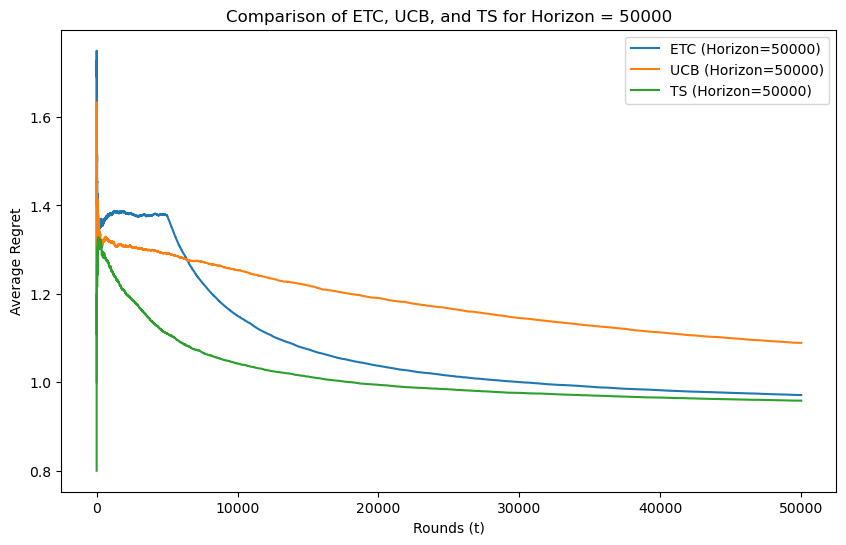

----------Running horizon 500000----------


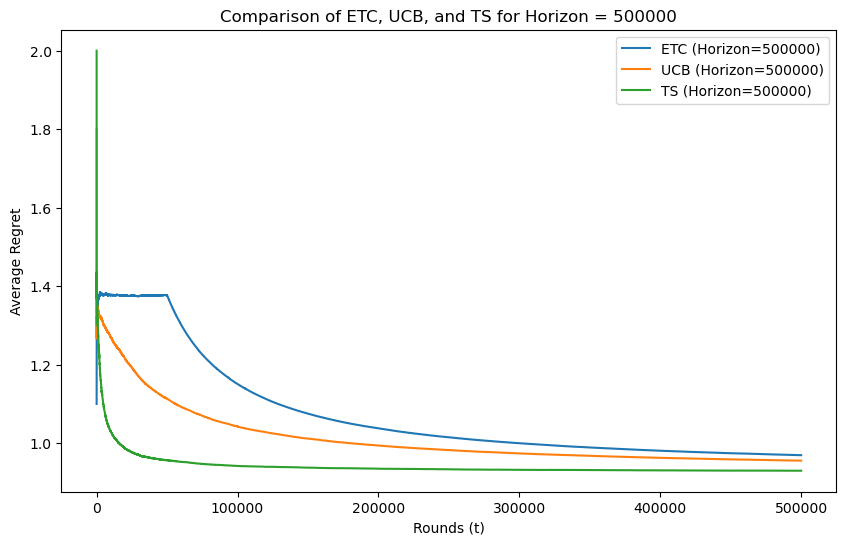

----------Running horizon 5000000----------


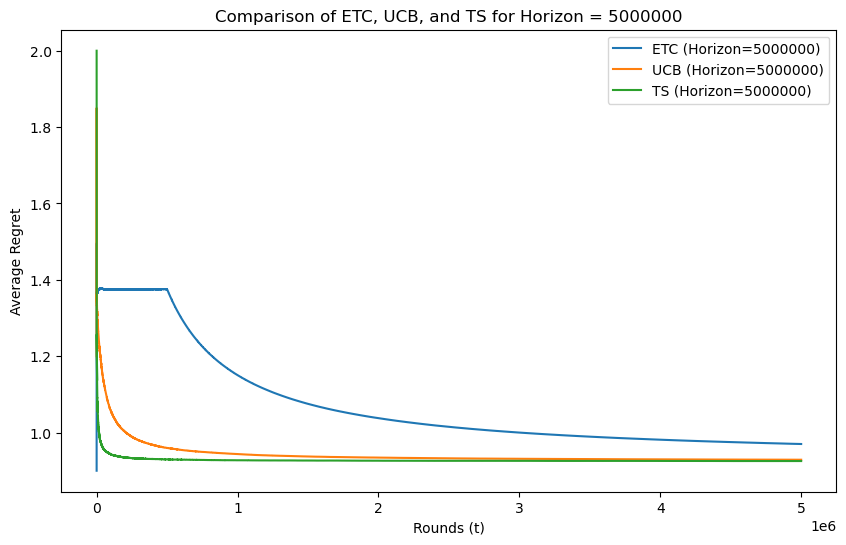

In [11]:
# Horizon values
horizons = [500, 5000, 50000, 500000, 5000000]
num_experiments = 100

def run_all_algorithms_for_horizon(horizon, arms_rewards_df, num_experiments):
    all_cumulative_regrets = {
        "ETC": [],
        "UCB": [],
        "TS": []
    }

    for _ in range(num_experiments):
        # ETC Algorithm
        etc = ETC(k=len(arms_rewards_df), n=horizon)
        etc.run(arms_rewards_df['Rating'], horizon)
        all_cumulative_regrets["ETC"].append(etc.cumulative_regret)
        
        # UCB Algorithm
        ucb = UCB(k=len(arms_rewards_df), n=horizon, B=4)
        ucb.run(arms_rewards_df['Rating'], horizon)
        all_cumulative_regrets["UCB"].append(ucb.cumulative_regret)
        
        # Thompson Sampling Algorithm
        ts = ThompsonSampling(k=len(arms_rewards_df), n=horizon, B=4)
        ts.run(arms_rewards_df['Rating'], horizon)
        all_cumulative_regrets["TS"].append(ts.cumulative_regret)
    
    return all_cumulative_regrets

for horizon in horizons:
    print(f"----------Running horizon {horizon}----------")
    cumulative_regrets = run_all_algorithms_for_horizon(horizon, arms_rewards_df, num_experiments)
    
    plt.figure(figsize=(10, 6))
    
    for alg in ["ETC", "UCB", "TS"]:
        mean_cumulative_regret = np.mean(cumulative_regrets[alg], axis=0)
        average_regret = mean_cumulative_regret / np.arange(1, horizon + 1)
        plt.plot(average_regret, label=f'{alg} (Horizon={horizon})')
    
    plt.xlabel('Rounds (t)')
    plt.ylabel('Average Regret')
    plt.title(f'Comparison of ETC, UCB, and TS for Horizon = {horizon}')
    plt.legend()
    plt.show()

The log curve was quite different from what we see in Assignment 2 for UCB algorithm. For less than 50000 rounds we choose, UCB has a bad performance in contrast to ETC and TS. And it lies in the middle when n is very large at 500000, converge to the same value as TS when n=5e6\
In small horizons like 500 and 5000, ETC quickly found the best arm and showed the lowest average regret. With n increasing, ETC spent too much on exploration so Thompson Sampling outstands. \


## Problem 3

In [12]:
class AOUCB:
    def __init__(self, k, n, B=4):
        self.k = k
        self.n = n
        self.B = B
        
        self.arm_means = np.zeros(k)
        self.arm_counts = np.zeros(k)
        
        self.cumulative_regret = np.zeros(n)
        self.average_regret = np.zeros(n)
    
    def select_arm(self, t):
        ucb_values = np.zeros(self.k)
        for i in range(self.k):
            if self.arm_counts[i] == 0:
                return i
            f_t = 1 + t * (np.log(t + 1))**2
            ucb_values[i] = self.arm_means[i] + self.B * np.sqrt(2 * np.log(f_t) / self.arm_counts[i])
        return np.argmax(ucb_values)
    
    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.arm_means[arm] += (reward - self.arm_means[arm]) / self.arm_counts[arm]
    
    def run(self, rewards, n):
        optimal_reward = 5
        for t in range(n):
            arm = self.select_arm(t)
            reward = random.choice(rewards[arm])
            self.update(arm, reward)
            regret = optimal_reward - reward
            self.cumulative_regret[t] = self.cumulative_regret[t - 1] + regret if t > 0 else regret
            self.average_regret[t] = self.cumulative_regret[t] / (t + 1)


Running experiment 1
Running experiment 2
Running experiment 3
Running experiment 4
Running experiment 5
Running experiment 6
Running experiment 7
Running experiment 8
Running experiment 9
Running experiment 10


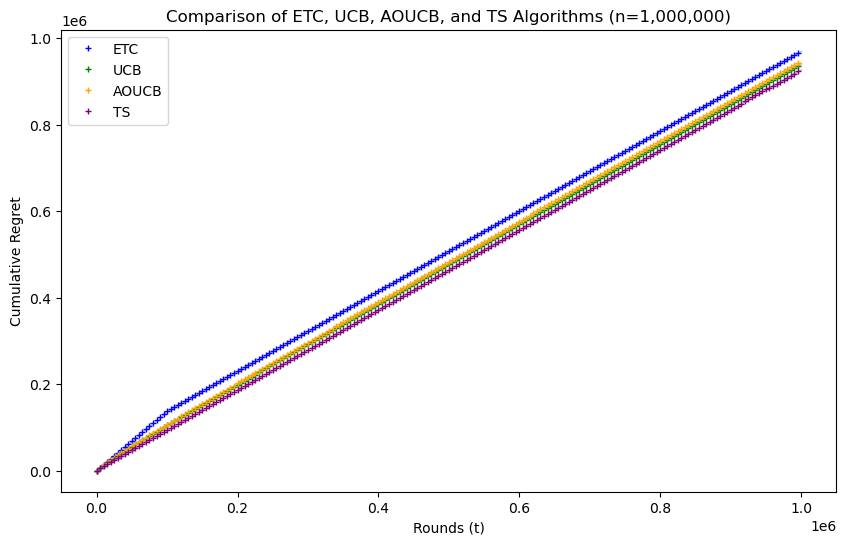

In [13]:
n = 1000000
num_experiments = 10

all_cumulative_regrets = {
    "ETC": [],
    "UCB": [],
    "AOUCB": [],
    "TS": []
}

def run_all_algorithms(n, arms_rewards_df, num_experiments):
    for _ in range(num_experiments):
        print(f"Running experiment {_+1}")
        # ETC Algorithm
        etc = ETC(k=len(arms_rewards_df), n=n)
        etc.run(arms_rewards_df['Rating'], n)
        all_cumulative_regrets["ETC"].append(etc.cumulative_regret)
        
        # UCB Algorithm
        ucb = UCB(k=len(arms_rewards_df), n=n, B=4)
        ucb.run(arms_rewards_df['Rating'], n)
        all_cumulative_regrets["UCB"].append(ucb.cumulative_regret)
        
        # AOUCB Algorithm
        aoucb = AOUCB(k=len(arms_rewards_df), n=n, B=4)
        aoucb.run(arms_rewards_df['Rating'], n)
        all_cumulative_regrets["AOUCB"].append(aoucb.cumulative_regret)
        
        # Thompson Sampling Algorithm
        ts = ThompsonSampling(k=len(arms_rewards_df), n=n, B=4)
        ts.run(arms_rewards_df['Rating'], n)
        all_cumulative_regrets["TS"].append(ts.cumulative_regret)

run_all_algorithms(n, arms_rewards_df, num_experiments)

plt.figure(figsize=(10, 6))

labels = ["ETC", "UCB", "AOUCB", "TS"]
colors = ["blue", "green", "orange", "purple"]

for idx, label in enumerate(labels):
    mean_cumulative_regret = np.mean(all_cumulative_regrets[label], axis=0)
    std_cumulative_regret = np.std(all_cumulative_regrets[label], axis=0)
    
    sampling_interval = 5000
    sampled_x = np.arange(0, n, sampling_interval)
    sampled_mean_regret = mean_cumulative_regret[::sampling_interval]
    
    plt.plot(sampled_x, sampled_mean_regret, '+', color=colors[idx], markersize=5, label=f'{label}')
    
    plt.fill_between(range(n), mean_cumulative_regret - std_cumulative_regret, mean_cumulative_regret + std_cumulative_regret, color=colors[idx], alpha=0.2)

plt.xlabel('Rounds (t)')
plt.ylabel('Cumulative Regret')
plt.title('Comparison of ETC, UCB, AOUCB, and TS Algorithms (n=1,000,000)')

plt.legend()
plt.show()


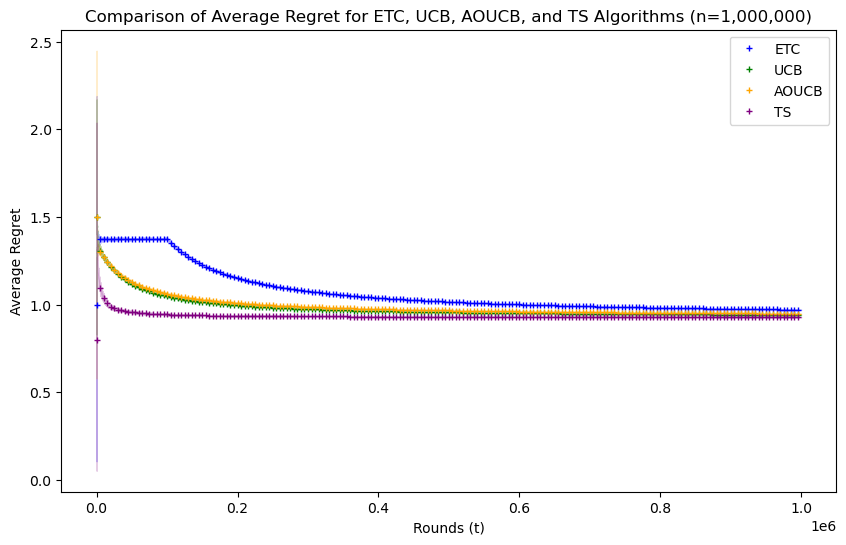

In [14]:
plt.figure(figsize=(10, 6))

labels = ["ETC", "UCB", "AOUCB", "TS"]
colors = ["blue", "green", "orange", "purple"]

for idx, label in enumerate(labels):
    mean_cumulative_regret = np.mean(all_cumulative_regrets[label], axis=0)
    std_cumulative_regret = np.std(all_cumulative_regrets[label], axis=0)
    
    average_regret = mean_cumulative_regret / np.arange(1, n + 1)
    std_average_regret = std_cumulative_regret / np.arange(1, n + 1)
    
    sampling_interval = 5000
    sampled_x = np.arange(0, n, sampling_interval)
    sampled_average_regret = average_regret[::sampling_interval]
    
    plt.plot(sampled_x, sampled_average_regret, '+', color=colors[idx], markersize=5, label=f'{label}')
    
    plt.fill_between(range(n), average_regret - std_average_regret, average_regret + std_average_regret, color=colors[idx], alpha=0.2)

plt.xlabel('Rounds (t)')
plt.ylabel('Average Regret')
plt.title('Comparison of Average Regret for ETC, UCB, AOUCB, and TS Algorithms (n=1,000,000)')

# Show legend and plot
plt.legend()
plt.show()


In this setting, TS has the best performance and ETC is the worst. UCB and AOUCB seems to be similar.